In [1]:
%matplotlib inline
import numpy as np
from numpy.fft import fft, ifft
from math import floor
from os import listdir
from os.path import isfile, join
import json
import matplotlib
from matplotlib.pyplot import plot, legend, title
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import zlib

plt.rcParams['figure.figsize'] = [6.4, 4.8]

## Data

In [2]:
data_base_dir = "/home/geosearchef/csi/csi-repo/data/"

In [3]:
full_moving_hand = join(data_base_dir, "full-setup-2021-03-24-workingAtheros/moving_hand_10cm/")

full_sitting_breathing = join(data_base_dir, "full-setup-2021-03-24-workingAtheros/sitting-breathing/")
full_sitting_not_breathing = join(data_base_dir, "full-setup-2021-03-24-workingAtheros/sitting-not-breathing/")

full_standing_breathing = join(data_base_dir, "full-setup-2021-03-24-workingAtheros/standing-breathing/")
full_standing_not_breathing = join(data_base_dir, "full-setup-2021-03-24-workingAtheros/standing_not_breathing/")

full_tx_loc_not_breathing = join(data_base_dir, "full-setup-2021-03-24-workingAtheros/tx_loc_not_breathing/")
full_rx_loc_not_breathing = join(data_base_dir, "full-setup-2021-03-24-workingAtheros/rx_loc_not_breathing/")

In [4]:
main_scenario_dir = full_moving_hand
data = {}

## Utility

In [5]:
def load_file(filename, scenario_dir):
    path = join(scenario_dir, filename)
    is_deflated = path.endswith(".deflate")
    if not isfile(path):
        if not is_deflated:
            return load_file(filename + ".deflate")
        else:
            raise Exception(f'File not found: ${path}')
    
    if not is_deflated:
        return open(path, "r").read()
    else:
        compressed_data = open(path, "rb").read()
        decompressed_data = zlib.decompress(compressed_data)
        return decompressed_data

def remove_outliers(array):
    mean = np.mean(array)
    std = np.std(array)
    newArray = []
    for i in range(len(array)):
        if abs(array[i] - mean) > 3.0 * std and i >= 1:
            newArray.append(newArray[i-1])
        else:
            newArray.append(array[i])
    
    return np.array(newArray)

## Data loading

In [6]:
def load_rescale_timestamps(station_data, start_time):
    entries = station_data['entries']
    
    if start_time is None: ## sync start time across all stations
        start_time = entries[0]["clientTimestamp"]
    
    for entry in entries:
        entry["clientTimestamp"] -= start_time
    total_duration_ms = max([entry["clientTimestamp"] for entry in entries])
    timestamps = [entry["clientTimestamp"] for entry in entries]
    timestamps_seconds = np.array(timestamps) / 1000.0
    
    station_data["start_time"] = start_time
    station_data["total_duration_ms"] = total_duration_ms
    station_data["timestamps"] = timestamps
    station_data["timestamps_seconds"] = timestamps_seconds
    
    return start_time

def load_csi_data(station_data):
    entries = station_data['entries']
    print(f"Recording with {len(entries)} csi entries, Converting...")
    
    if "intelCsiNotification" in entries[0]:
        chip_timestamp_offset = -entries[0]["intelCsiNotification"]["timestamp_low"]
        csi_timestamps_chip = [((entry["intelCsiNotification"]["timestamp_low"]+chip_timestamp_offset) / 1000) for entry in entries]
        station_data["timestamps_chip"] = csi_timestamps_chip
        print("Found and loaded µs timestamps from intel chip ")
    
    
    csi_complex = [[[[(complex(0,0) if c is None else complex(c["real"], c["imag"])) for c in tx] for tx in rx] for rx in entry["csi_matrix"]] for entry in entries]
    csi_amplitudes = [[[[np.abs(c) for c in tx] for tx in rx] for rx in packet] for packet in csi_complex]
    csi_complex = np.array(csi_complex)
    csi_amplitudes = np.array(csi_amplitudes)
    
    print("Converting phases...")
    csi_phases_uncorrected = [[[[np.angle(c) for c in tx] for tx in rx] for rx in packet] for packet in csi_complex]
    csi_phases_uncorrected = np.array(csi_phases_uncorrected)
    
    # correct phase
    csi_phases = np.copy(csi_phases_uncorrected)
    for packet in csi_phases:
        for rx in packet:
            for tx in rx:
                for i in range(30):
                    tx[i] = tx[i] + i * ((4.0 * 2.0 * np.pi) / 30.0)
                    tx[i] = (tx[i] + np.pi) % (2 * np.pi) - np.pi
                    if i >= 1 and tx[i] - tx[i-1] > np.pi:
                        tx[i] = tx[i] - 2*np.pi
                    if i >= 1 and tx[i-1] - tx[i] > np.pi:
                        tx[i] = tx[i] + 2*np.pi

    # unwrap phase data
    #csi_phases_unwrapped = np.copy(csi_phases)
    #for packet in csi_phases_unwrapped:
    #    for rx in packet:
    #        for tx in rx:
    #            for i in range(30):
    #                if i >= 1 and tx[i] - tx[i-1] > np.pi:
    #                    tx[i] = tx[i] - 2*np.pi
    #                if i >= 1 and tx[i-1] - tx[i] > np.pi:
    #                    tx[i] = tx[i] + 2*np.pi
    
    station_data["csi_complex"] = csi_complex
    station_data["csi_amplitudes"] = csi_amplitudes
    station_data["csi_phases"] = csi_phases
    
    print("Done.")
    
def load_accel_data(station_data):
    entries = station_data['entries']
    print(f"Recording with {len(entries)} accel entries, Converting...")
    station_data["accel_x"] = np.array([entry["data"][0] - entry["calibration"][0] for entry in station_data['entries']])
    station_data["accel_y"] = np.array([entry["data"][1] - entry["calibration"][1] for entry in station_data['entries']])
    station_data["accel_z"] = np.array([entry["data"][2] - entry["calibration"][2] for entry in station_data['entries']])
    print("Done.")
    
    
def load_ecg_data(station_data):
    entries = station_data['entries']
    print(f"Recording with {len(entries)} ecg entries, Converting...")
    station_data["ecg_values"] = np.array([entry["value"] for entry in station_data['entries']])
    print("Done.")
    

In [7]:
def load_station_data(station_data, start_time):
    files = station_data['entries']
    first_file = files[0]
    if len(files) == 0:
        return
    
    start_time = load_rescale_timestamps(station_data, start_time)
    
    dataType = None
    subType = None
    if "atherosCsiStatus" in first_file:
        dataType = "csi"
        subType = "atheros"
        load_csi_data(station_data)
    elif "intelCsiNotification" in first_file:
        dataType = "csi"
        subType = "intel"
        load_csi_data(station_data)
    elif "firstWordInvalid" in first_file:
        dataType = "csi"
        subType = "esp"
        load_csi_data(station_data)
    elif "calibration" in first_file:
        dataType = "acceleration"
        subType = "android"
        load_accel_data(station_data)
    elif "value" in first_file:
        dataType = "ecg"
        subType = "esp"
        load_ecg_data(station_data)
    
    station_data["dataType"] = dataType
    station_data["subType"] = subType
    return start_time

In [8]:
def reload_recording(scenario_dir):
    data['room'] = json.loads(load_file("room.cfg", scenario_dir))
    
    recording_files = sorted(filter(lambda f: f.endswith(".ecg") or f.endswith(".ecg.deflate") or f.endswith(".accel") or f.endswith(".accel.deflate") or f.endswith(".csi") or f.endswith(".csi.deflate"), listdir(scenario_dir)))
    data['stations'] = {}
    start_time = None # sync start time across all stations
    for station in data['room']['stations']:
        hw_address = station['HW_ADDRESS']
        station_files = list(filter(lambda f: f.startswith(hw_address) or f.startswith(station['IP_ADDRESS'].replace("/", "_")), recording_files))

        station_data = {
            "name": station['HW_ADDRESS'],
            "entries": []
        }
        for file in station_files:
            packet = json.loads(load_file(file, scenario_dir))
            for entry in packet:
                station_data["entries"].append(entry)
                
        station_data["entries"].sort(key = lambda e: e["clientTimestamp"])
        
        start_time = load_station_data(station_data, start_time)
        
        data['stations'][station_data["name"]] = station_data
        
    
    print("\n")
    for name, station in data['stations'].items():
        print(f"Found {len(station['entries'])} entries, {station['total_duration_ms']} ms for station {station['dataType']}/{station['subType']}, name: {station['name']}")

    
reload_recording(main_scenario_dir)
data['csi-atheros'] = data["stations"]["90:f6:52:4e:c5:ba"]
data['csi-intel'] = data["stations"]["00:16:ea:ef:f1:14"]
data['csi-esp'] = data["stations"]["esp-csi"]
data['accel'] = data["stations"]["android"]
data['ecg'] = data["stations"]["esp-ecg"]


Recording with 1917 csi entries, Converting...
Converting phases...
Done.
Recording with 1768 csi entries, Converting...
Found and loaded µs timestamps from intel chip 
Converting phases...
Done.
Recording with 448 csi entries, Converting...
Converting phases...
Done.
Recording with 1027 accel entries, Converting...
Done.
Recording with 1159 ecg entries, Converting...
Done.


Found 1917 entries, 23149 ms for station csi/atheros, name: 90:f6:52:4e:c5:ba
Found 1768 entries, 23156 ms for station csi/intel, name: 00:16:ea:ef:f1:14
Found 448 entries, 23047 ms for station csi/esp, name: esp-csi
Found 1027 entries, 23162 ms for station acceleration/android, name: android
Found 1159 entries, 23157 ms for station ecg/esp, name: esp-ecg


## Sampling

In [9]:
def sample_signal(signal, timestamps, sampling_times):
        result_signal = []
        for t in sampling_times:
            closest_index = np.argmin(np.abs(timestamps - t))
            if timestamps[closest_index] > t:
                upper_index = closest_index
                lower_index = closest_index - 1
            else:
                upper_index = closest_index + 1
                lower_index = closest_index
            
            upper_index = min(upper_index, len(timestamps) - 1)
            lower_index = max(lower_index, 0)
            
            # interpolate
            lower_timestamp = timestamps[lower_index]
            upper_timestamp = timestamps[upper_index]
            if lower_timestamp != upper_timestamp:
                f = (t - lower_timestamp) / (upper_timestamp - lower_timestamp)
            else:
                f = 0.0
            interpolated_value = signal[upper_index] * f + signal[lower_index] * (1.0 - f)
            
            result_signal.append(interpolated_value)
        return result_signal
    
def resample_signal(resample, resampling_freq, signal, timestamps):
    if resample:
        sampling_times = np.arange(0, max(timestamps) / 1000.0, 1.0 / resampling_freq) * 1000.0
        return sampling_times, sample_signal(signal, timestamps, sampling_times)
    else:
        return timestamps, signal

## Processing

In [10]:
def amplitude_signal(manufacturer, rx, tx, carrier, resample=True, resampling_freq=100):
    recording = data["csi-" + manufacturer]
    return resample_signal(resample, resampling_freq, recording["csi_amplitudes"][:,rx,tx,carrier], recording["timestamps"])
def phase_signal(manufacturer, rx, tx, carrier, resample=True, resampling_freq=100):
    recording = data["csi-" + manufacturer]
    return resample_signal(resample, resampling_freq, recording["csi_phases"][:,rx,tx,carrier], recording["timestamps"])
def accel_signal_y(resample=True, resampling_freq=100):
    recording = data["accel"]
    return resample_signal(resample, resampling_freq, recording["accel_y"], recording["timestamps"])
def ecg_signal(resample=True, resampling_freq=100):
    recording = data["ecg"]
    return resample_signal(resample, resampling_freq, recording["ecg_values"], recording["timestamps"])

## Test

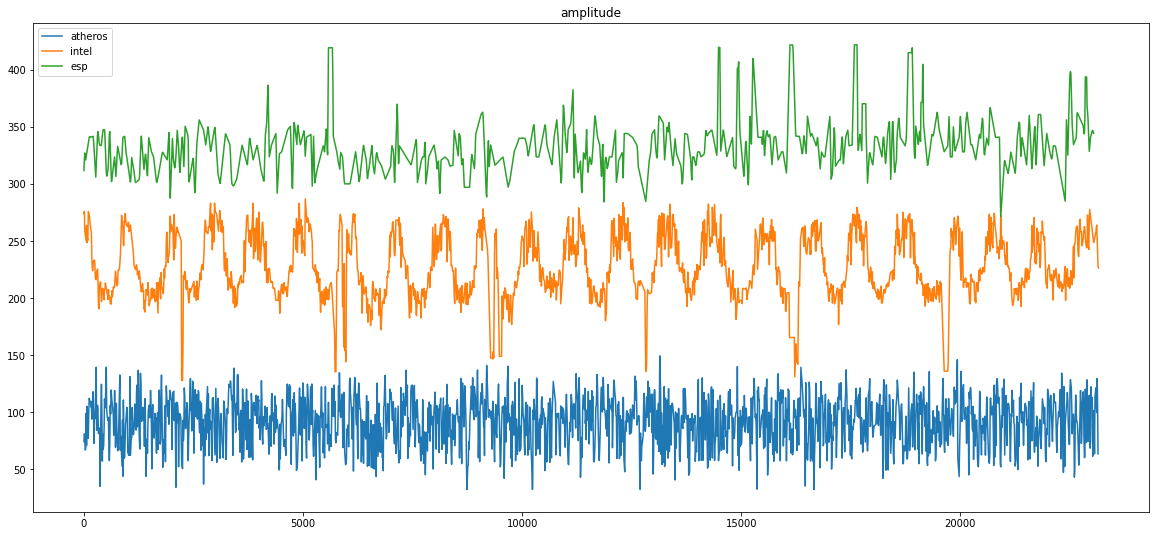

In [13]:
plt.rcParams['figure.figsize'] = [20, 9]

ath_t, ath_v = amplitude_signal("atheros", 0, 0, 15)
plot(ath_t, ath_v, label="atheros")
#plot(ath_t, savgol_filter(ath_v, 51, 3))

int_t, int_v = amplitude_signal("intel", 0, 0, 15)
int_v = remove_outliers(int_v)
plot(int_t, int_v, label="intel")
#plot(int_t, savgol_filter(int_v, 51, 3))

esp_t, esp_v = amplitude_signal("esp", 0, 0, 15)
esp_v = remove_outliers(esp_v)
plot(esp_t, esp_v + 100, label="esp")
#plot(esp_t, savgol_filter(esp_v+100, 51, 3))

title("amplitude")
legend()

Text(0.5, 1.0, 'phase')

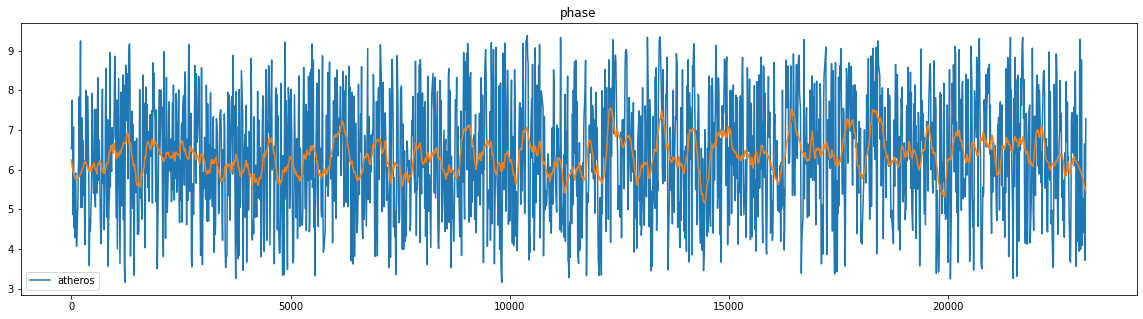

In [12]:
plt.rcParams['figure.figsize'] = [20, 5]

ath_t, ath_v = phase_signal("atheros", 0, 0, 15)
plot(ath_t, ath_v, label="atheros")
plot(ath_t, savgol_filter(ath_v, 51, 3))

legend()
title("phase")

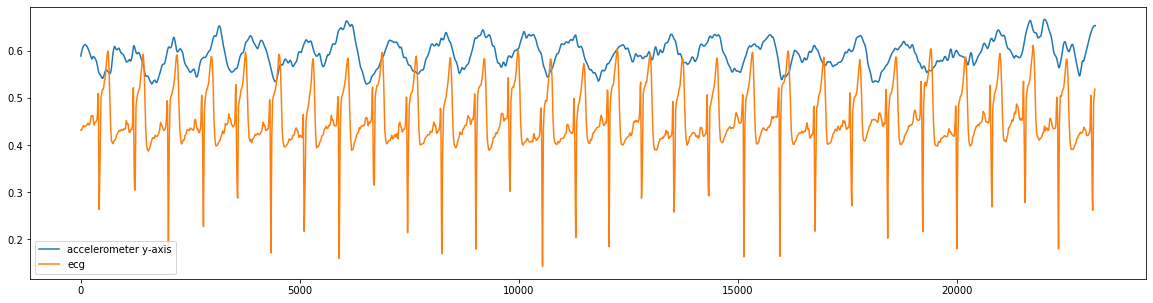

In [13]:
accel_t, accel_v = accel_signal_y()
ecg_t, ecg_v = ecg_signal()

plot(accel_t, savgol_filter(accel_v, 51, 3), label="accelerometer y-axis")
plot(ecg_t, ecg_v, label="ecg")

legend()